Author: Lee Clemmer

# Introduction

In this notebook we'll explore the Ames, Iowa Housing Dataset, prepared by Dean De Cock, and described in the paper *[Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)*.

We start by conducting some exploratory data analysis followed by processing the data based on our findings. The goal is ultimately to accurately predict the sales price of houses in the test set given the data in the training set.

# Acknowledgements

This notebook marks the end of my lurker status on Kaggle and my first foray into publishing kernels here. I'd like to call out several other notebooks that were tremendously valuable in helping me put this together, generate ideas, and learn a lot.

* **[Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)** by Pedro Marcelina (most entertaining notebook ever btw)
* **[A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)** by juliencs
* **[House Prices EDA](https://www.kaggle.com/dgawlik/house-prices-eda)** by Dominik Gawlik
* **[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)** by Serigne
* **[Python Machine Learning (Book)](https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka/dp/1783555130)** by Sebastiona Raschka

Of course a big shout out to the Google and StackOverflow for promptly delivering answers to my many questions.

# Table of Contents

* Discussion and Background
* Intuition
* Univariate Analysis
* Multivariate Analysis
* Data Preprocessing
* Modeling

# Discussion and Background

Without doing any analysis of the data itself we can learn a lot by simply reading the documentation:
* [Original dataset](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt)
* [Dataset documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)

From the documentation, we learn that the there are **2,930 observations** and **82 variables**, two of which (Order and Parcel ID) are not included in the dataset given in this competition. 

*Sidebar:* The Parcel ID actually allows us to look up individual parcels on the [Ames Assessor's Office's website](http://www.cityofames.org/government/departments-divisions-a-h/city-assessor) (click on "Property Search" and put in the PID on the search page). [Here](https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1957777753&KeyValue=0526301100), for example, is the parcel of Obervation No. 1 in the original dataset. The Assessor's Office, incidentially, is also the source of the data itself. 

The properties were sold in Ames, IA from 2006 to 2010. This raises some questions, such as "do properties appear more than once if there were repeatedly sold in the time period?" or "does the data include time of sale?" As I go through the data I like to keep a list of open questions that I can come back to later. 

Before we dive into the variables, let's look at the *Special Notes* section of the documentation, which informs us: 
> There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

Let's be sure to check out these outliers and consider whether we want to in fact exclude any houses bigger than 4,000 sq ft.

Finally, the documentation also references a couple of papers that may help us with our analysis:
* [Kuiper , S. (2008), “Introduction to Multiple Regression: How Much Is Your Car Worth?”, Journal of Statistics Education Volume 16, Number 3 (2008).](http://ww2.amstat.org/publications/jse/v16n3/datasets.kuiper.html)
* [Pardoe , I. (2008), “Modeling home prices using realtor data”, Journal of Statistics Education Volume 16, Number 2 (2008).](http://ww2.amstat.org/publications/jse/v16n2/datasets.pardoe.html)

Ok, let's dive into the data.


# Intuition: getting to know the data
Before we start our more rigorous analysis, let's start by familiarizing ourselves with the data first. We don't need to look at every feature (yet), but getting a feel for some features that are immediately relevant to us may help us build some intuition and generate ideas or questions.

## Imports and Data Load

In [1]:
# Imports
import math

import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
# Let's get some data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## High Level Overview
Let's begin by getting high-level look at our data.

In [3]:
# How is our data shaping up?
print('Our training dataset has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))
print('Our test dataset has {} rows and {} columns.'.format(test.shape[0], test.shape[1]))

Our training dataset has 1460 rows and 81 columns.
Our test dataset has 1459 rows and 80 columns.


In [4]:
# Take a sneak peak at the data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head() # obviously missing the SalePrice

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# Get info on our columns and data size
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

For larger datasets it pays off to load categorical variables as such (instead of as dtype "object"), but with a memory footprint of 3.9 MB we're not exactly dealing with Big Data :) For a great article on this topic, check out ["Using pandas with large data"](https://www.dataquest.io/blog/pandas-big-data/).

## Poking around
Now that we have a 50,000 ft view of the data, let's start poking around and ask some questions based on our existing knowledge of housing in general, without yet going into the weeds of every feature.

The cheapest house sold for $34,900 and the most expensive for $755,000
The average sales price is $180,921, while median is $163,000


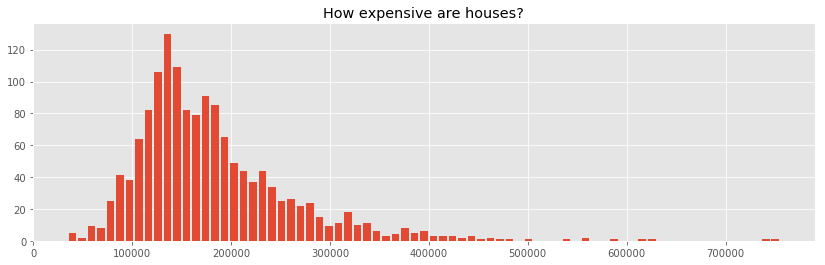

In [7]:
# How expensive are houses?
print('The cheapest house sold for ${:,.0f} and the most expensive for ${:,.0f}'.format(
    train.SalePrice.min(), train.SalePrice.max()))
print('The average sales price is ${:,.0f}, while median is ${:,.0f}'.format(
    train.SalePrice.mean(), train.SalePrice.median()))
train.SalePrice.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('How expensive are houses?')
plt.show()

We note that the distribution is positively skewed to the right with a good number of outliers.

Oldest house built in 1872. Newest house built in 2010.


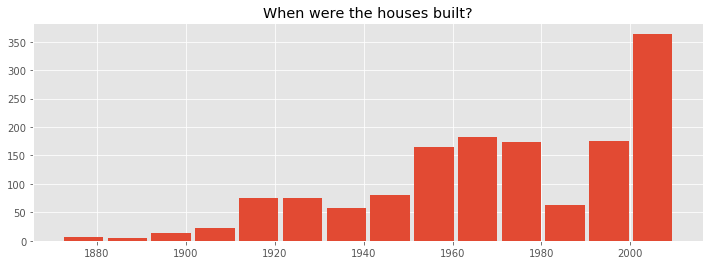

In [8]:
# When were the houses built?
print('Oldest house built in {}. Newest house built in {}.'.format(
    train.YearBuilt.min(), train.YearBuilt.max()))
train.YearBuilt.hist(bins=14, rwidth=.9, figsize=(12,4))
plt.title('When were the houses built?')
plt.show()

Not much action in the 80s apparently. Looks like majority of houses were built in the 50s and after, which good chunk of new houses built in the aughts.

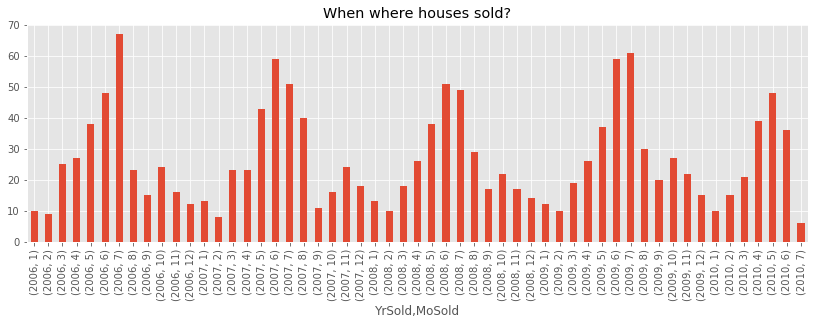

In [9]:
# When where houses sold?
train.groupby(['YrSold','MoSold']).Id.count().plot(kind='bar', figsize=(14,4))
plt.title('When where houses sold?')
plt.show()

So this is interesting. We see a strong seasonal pattern in house sales, with peaks in June and July. We verify that the dataset spans 2006 to 2010, but note that data steps mid-year in July of 2010.

At this point I'm wondering if the time of year a house is sold has any effect on sales price. We'll address this question once we start our multivariate analysis later on.

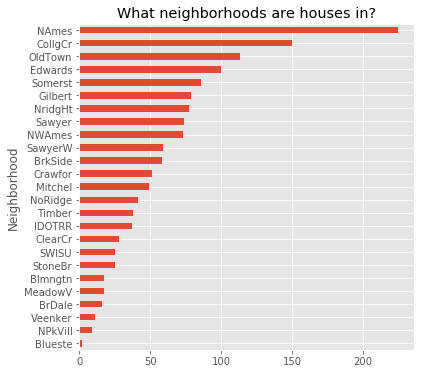

In [10]:
# Where are houses?
train.groupby('Neighborhood').Id.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What neighborhoods are houses in?')
plt.show()

Looks like a good chunk of houses are in North Ames, Collect Creek, and Old Town, with few houses in Bluestem, Northpark Villa and Veenker.

If there's any truth to the real estate dictum "location, location, location" we should see this feature correlate with the Sales Price. It would also be interesting to augment the dataset with additional information as it relates to neighborhoods. For example, from my own time spent on Zillow, there seems to be an undeniable correlation between house prices and school quality, the latter of which is not capture in our dataset.

The average house has 1,515 sq ft of space, the median 1,464 sq ft
The biggest house has 5,642 sq ft of space, the smallest 334 sq ft


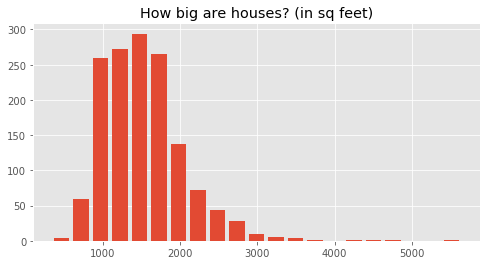

In [11]:
# How big are houses
print('The average house has {:,.0f} sq ft of space, the median {:,.0f} sq ft'.format(
    train.GrLivArea.mean(), train.GrLivArea.median()))
print('The biggest house has {:,.0f} sq ft of space, the smallest {:,.0f} sq ft'.format(
    train.GrLivArea.max(), train.GrLivArea.min()))
train.GrLivArea.hist(bins=21, rwidth=.8, figsize=(8,4))
plt.title('How big are houses? (in sq feet)')
plt.show()

Here's the smallest house (334 sq ft):
<img src="https://beacon.schneidercorp.com/PhotoEngine/Photo/165/0534450090/0/1.jpg" />

And the biggest house (5,642 sq ft):
<img src="https://beacon.schneidercorp.com/PhotoEngine/Photo/165/0908154235/1/1.jpg" />

The average lot is 0.24 acres, the median 0.22 acres
The biggest lot is 4.94 acres, the smallest 0.03 acres


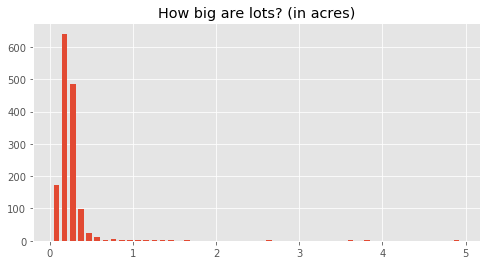

In [12]:
# How big are lots
sqft_to_acres = 43560.
print('The average lot is {:,.2f} acres, the median {:,.2f} acres'.format(
    train.LotArea.mean()/sqft_to_acres, train.LotArea.median()/sqft_to_acres))
print('The biggest lot is {:,.2f} acres, the smallest {:,.2f} acres'.format(
    train.LotArea.max()/sqft_to_acres, train.LotArea.min()/sqft_to_acres))
(train.LotArea/sqft_to_acres).hist(bins=50, rwidth=.7, figsize=(8,4))
plt.title('How big are lots? (in acres)')
plt.show()

We can see that both the square footage of a house and lot size are positively skewed, but lot size much more so with plenty of outliers. I expect both of these to show significant correlation with sales price. 

Ok, that's good for now. We took a look at how expensive houses are, when they were built, where they are, and how big they and the lots they're on are. 

Let's now dive into the details more systematically.

# Univariate Analysis

In [13]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding SalePrice and Id. """
    # Numerical Features
    num_features = train.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['Id','SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

## Numerical Features

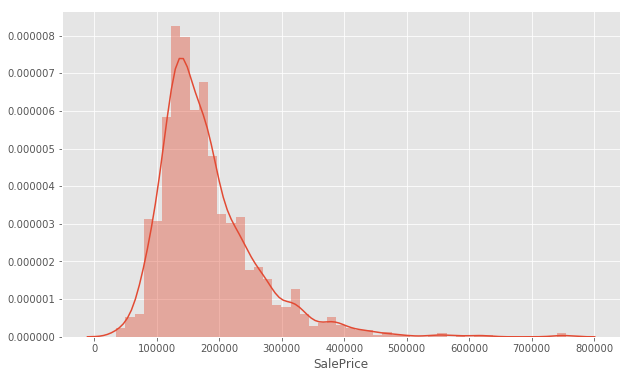

In [14]:
# Let's start with our dependent variable, SalePrice
plt.figure(figsize=(10,6))
sns.distplot(train.SalePrice)
plt.show()

We see that SalePrice is positively skewed. In fact, we get:

In [15]:
print('Skew: {:.3f} | Kurtosis: {:.3f}'.format(
    train.SalePrice.skew(), train.SalePrice.kurtosis()))

Skew: 1.883 | Kurtosis: 6.536


So it's positively skewed and "peaky" with fat tails, or outliers, namely to the right. We'll be transforming this feature later on. 

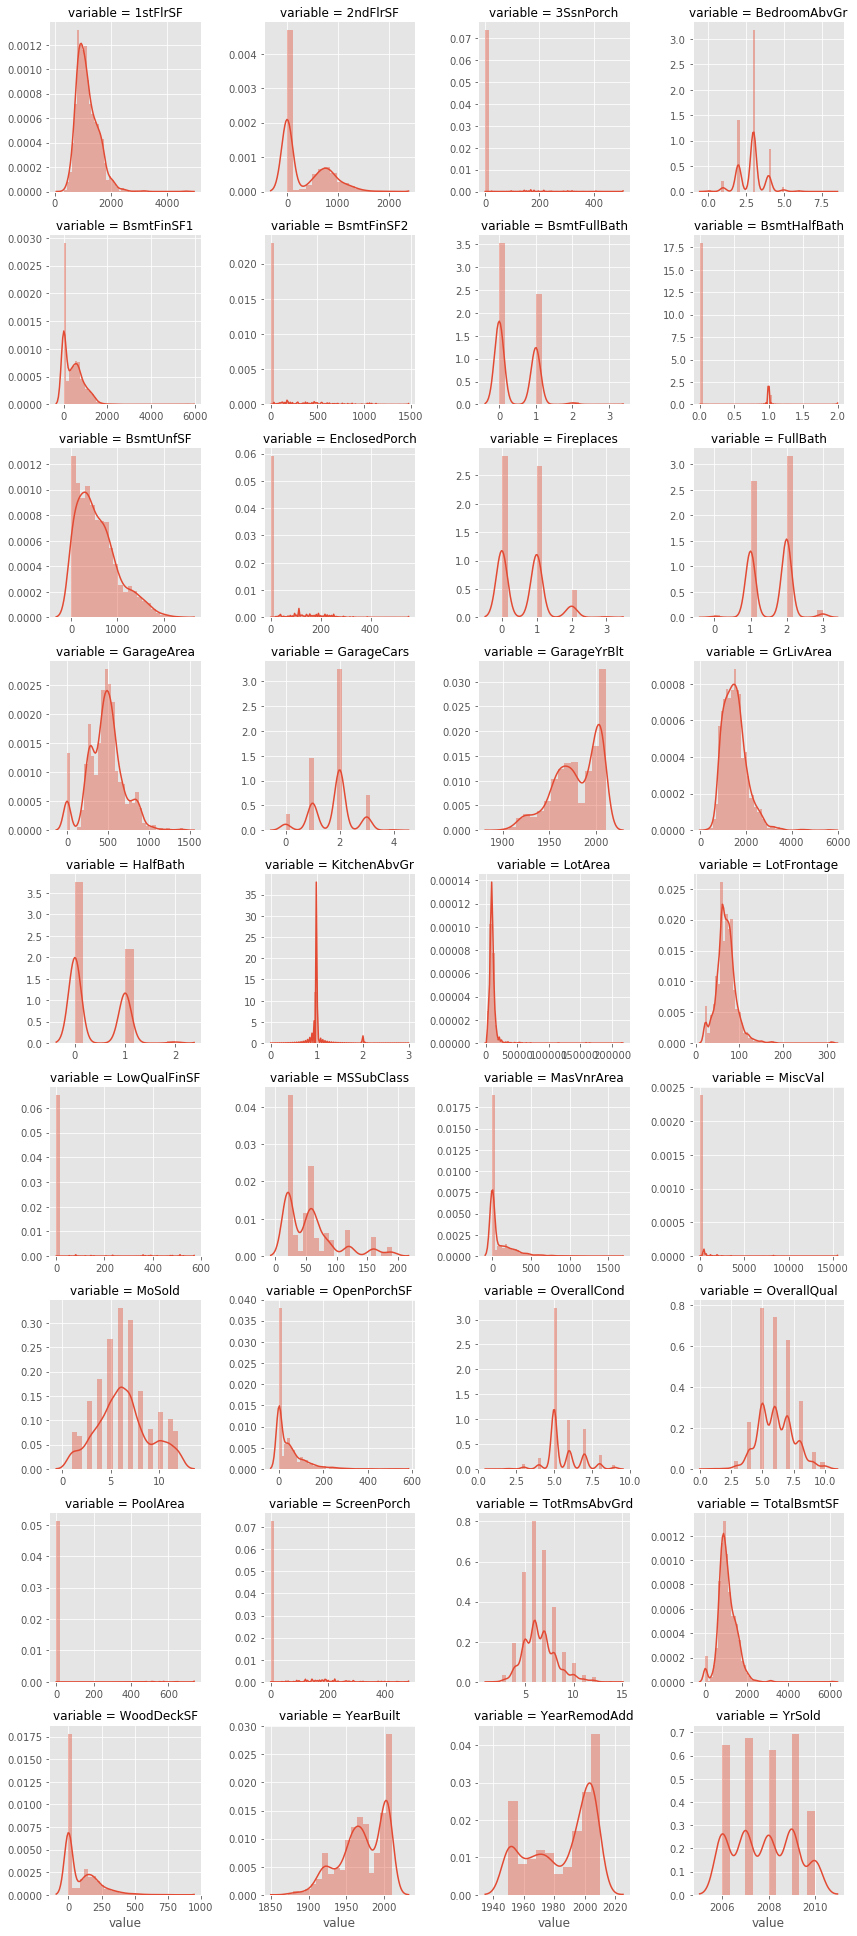

In [16]:
# Grid of distribution plots of all numerical features
f = pd.melt(train, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

We see a bunch of features that look positively skewed, similar to *SalePrice*. We'll want to log transform these, include: *LotFrontage, LotArea, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, GrLivAre, GarageArea*

Some features can be considered as count data, and maybe [we don't want to transform them?](http://onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2010.00021.x/abstract;jsessionid=9283C2745CFF8F62B3D9E48E9D463F30.f04t04) *(Note to self: look more deeply into this issue*): *BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotalRmsAbvGr, Fireplaces, GarageCars*

We see time related features: *YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold*

We note that *MSSubclass* should really be categorical, and make a note to ourselves to take care of this when we process the data later on. For purposes of regression, we should also treat *MoSold* as categorical as the Euclidean distance between them doesn't make sense in this application. Same for *YrSold*. For YearBuilt, however, the distance is relevant as it implies age of the house.

Finally, we have plenty of sparse features that have a large zero count, e.g. PoolArea, which is 0 for houses that have no pool. We'll have to think about how to handle these. 

Let's take a closer look.

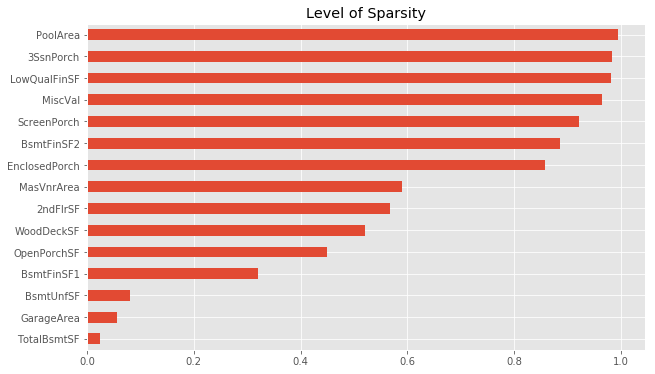

In [17]:
# Percentage of zero values
count_features = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                  'KitchenAbvGr','TotalRmsAbvGr','Fireplaces','GarageCars']
non_count_features = [f for f in num_features if f not in count_features]
sparse_features = (train[non_count_features] == 0).sum() / train.shape[0]
sparse_features[sparse_features > 0].\
    sort_values(ascending=True).\
    plot(kind='barh', figsize=(10,6))
plt.title('Level of Sparsity')
plt.show()

## Categorical Features

In [18]:
# First off, earlier we said we'll need to transform
# a couple features to categorical. Since we're looking 
# at categorical data here, let's go ahead and do that now
# so they are included in the analysis.
train['MSSubClass'] = train.MSSubClass.apply(lambda x: str(x))
train['MoSold'] = train.MoSold.apply(lambda x: str(x))
train['YrSold'] = train.YrSold.apply(lambda x: str(x))

# Update our list of numerical and categorical features
num_features, cat_features = get_feature_groups()

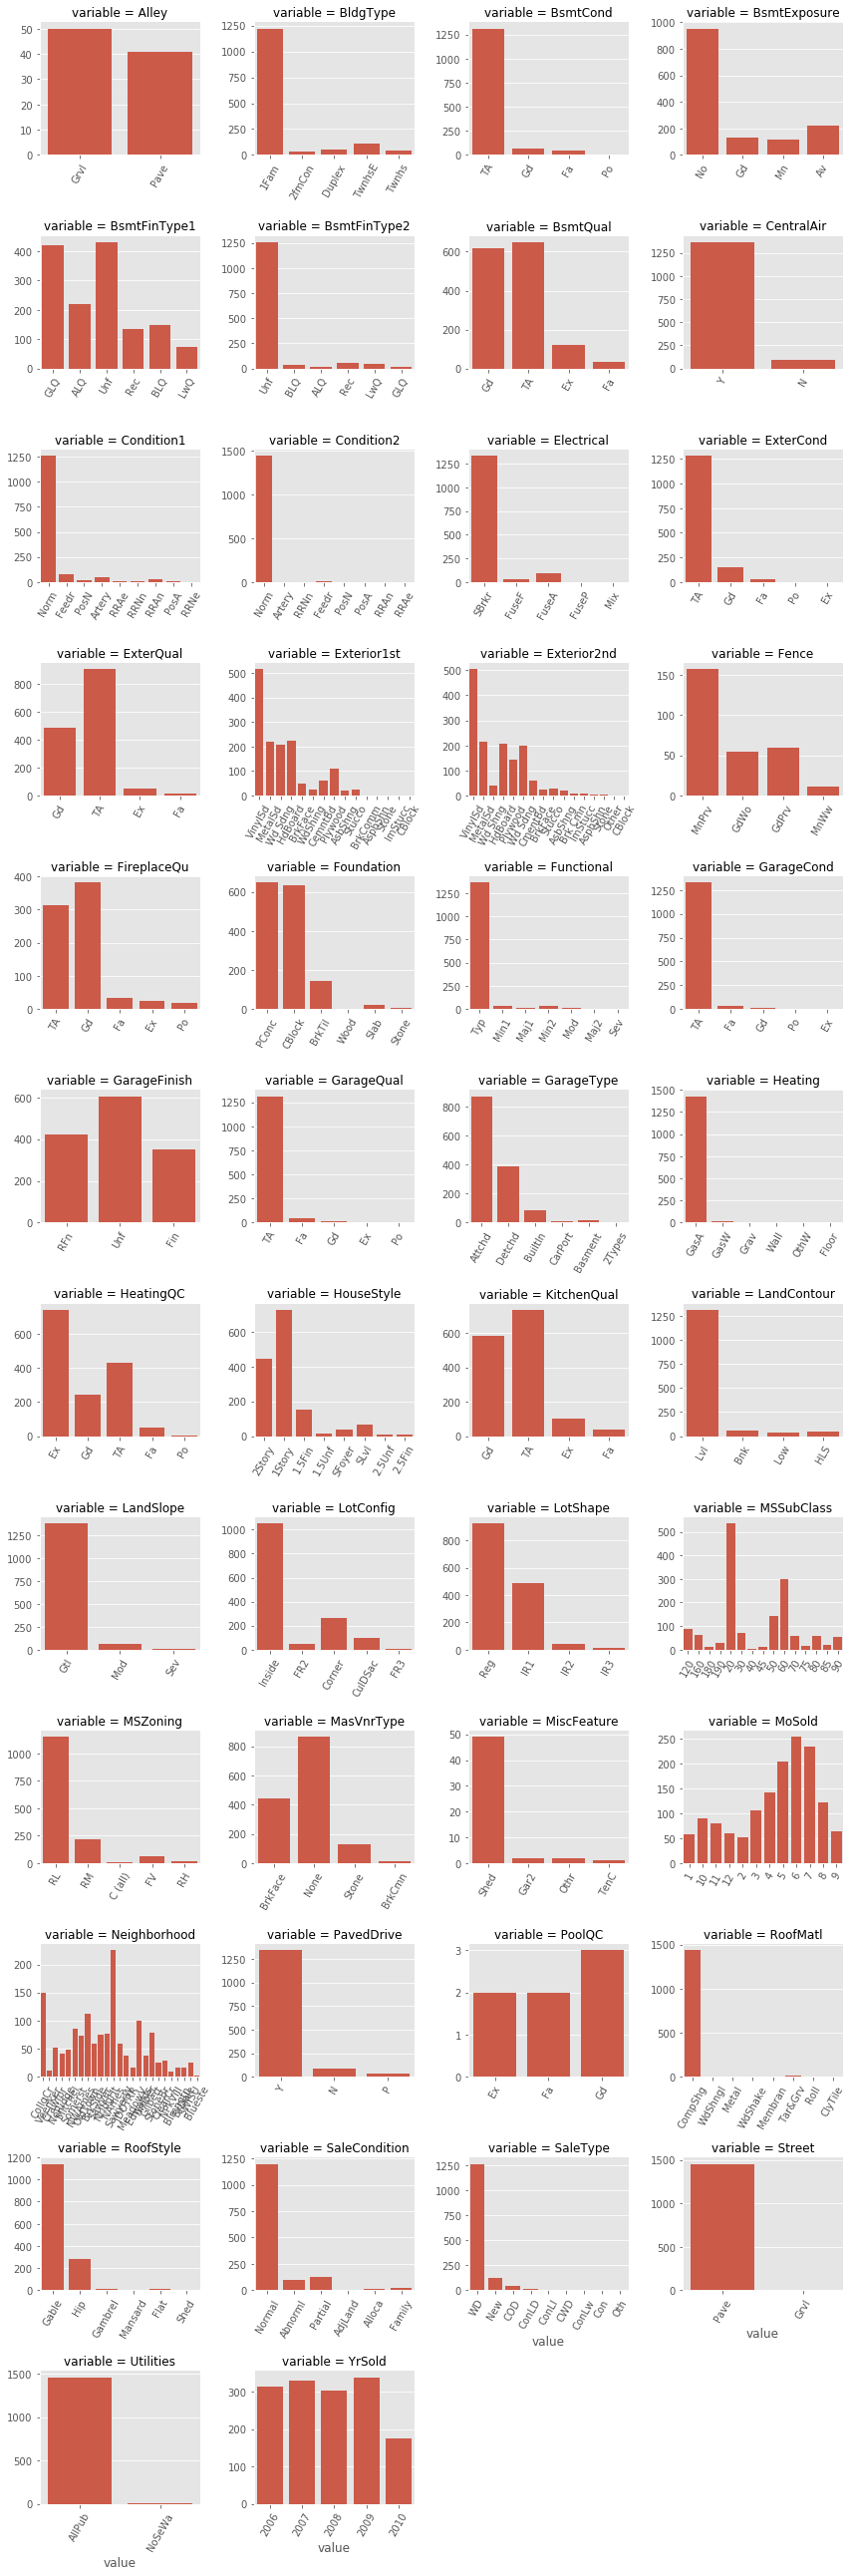

In [19]:
# Count plots of categorical features
f = pd.melt(train, value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

The categorical features will be much more interesting when compaired to our target feature SalePrice, but we can note a couple of things nevertheless. First, we note that there are plenty of feature were one value is heavily overrpresented, e.g. *Condition2* (Proximity to various conditions (if more than one is present)), where nearly 99% of houses are listed as "Norm". That's fine though, as those edge cases may help us predict outliers.

The second thing to realize is that a number of categorical features actually contain rank information in them and should thus be converted to discrete quantitative features similar to *OverallQual*. For example, *ExterQual* has the following values:
* Ex - Excellent
* Gd - Good
* TA - Average/Typical
* Fa - Fair
* Po - Poor

We should change these to be 1 to 5. We'll do that for the following features: *Alley, LotShape, LandContour, Utilities, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQuality, GarageCond, PavedDrive, PoolQC*

Looks like we had a bunch of numerical features hiding out amongst the categorical fellas!

# Bivariate Analysis

In [20]:
# In the last section we identified a list of features
# that we want to change from categorical to numerical
# because the contain ranked information (e.g. quality ratings).
# We'll make those transforms now already so that they are
# properly included in the following section.
# We're also going to replace missing values with 0 already.

# Alley
train.Alley.replace({'Grvl':1, 'Pave':2}, inplace=True)

# Lot Shape
train.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)

# Land Contour
train.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)

# Utilities
train.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)

# Land Slope
train.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)

# Exterior Quality
train.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Exterior Condition
train.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Quality
train.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Condition
train.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Exposure
train.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)

# Finished Basement 1 Rating
train.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Finished Basement 2 Rating
train.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Heating Quality and Condition
train.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Kitchen Quality
train.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Home functionality
train.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)

# Fireplace Quality
train.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Finish
train.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)

# Garage Quality
train.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Condition
train.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Paved Driveway
train.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)

# Pool Quality
train.PoolQC.replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# We'll set all missing values in our newly converted features to 0
converted_features = ['Alley','LotShape','LandContour','Utilities','LandSlope','ExterQual','ExterCond',
        'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
        'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
        'GarageCond','PavedDrive','PoolQC']
train[converted_features] = train[converted_features].fillna(0)

# Update our list of numerical and categorical features
num_features, cat_features = get_feature_groups()

## Numerical Features

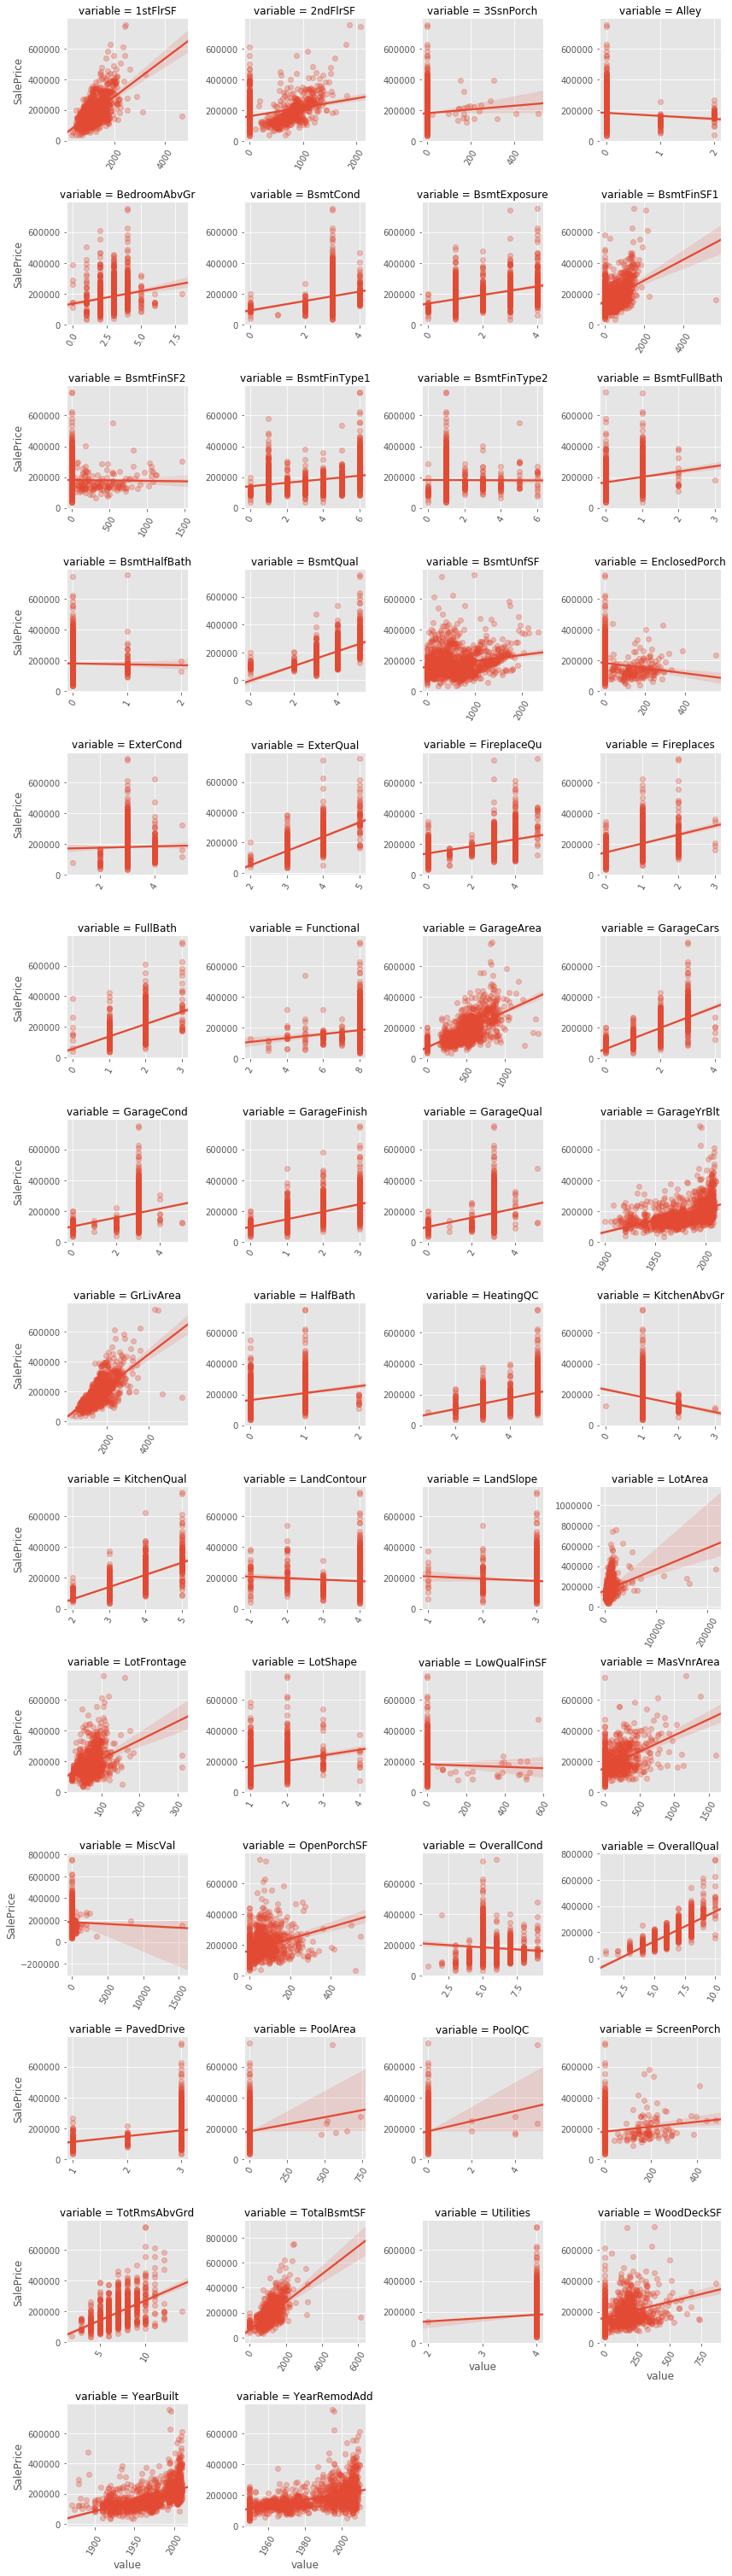

In [21]:
# Scatter plots of numerical features against SalePrice
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

We find that there are quite a few features that seem to show strong correlation to SalePrice, such as OverallQual, TotalBsmtSF, GrLivArea, and TotRmsAbvGrd. This confirms our natural intuition: we would expect that high quality, big house with big basements and lots of rooms to be more expensive.

We also note the occurrence of cone shapes, an artifact of our skewed distributions. Once we log transform some of these features, the relationship will be more linear.

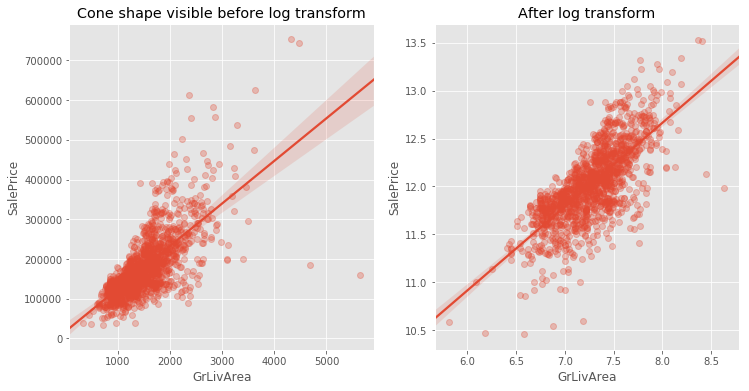

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.regplot(train.GrLivArea, train.SalePrice, scatter_kws={'alpha':0.3})
plt.title('Cone shape visible before log transform')

plt.subplot(122)
sns.regplot(np.log1p(train.GrLivArea), np.log1p(train.SalePrice), scatter_kws={'alpha':0.3})
plt.title('After log transform')
plt.show()

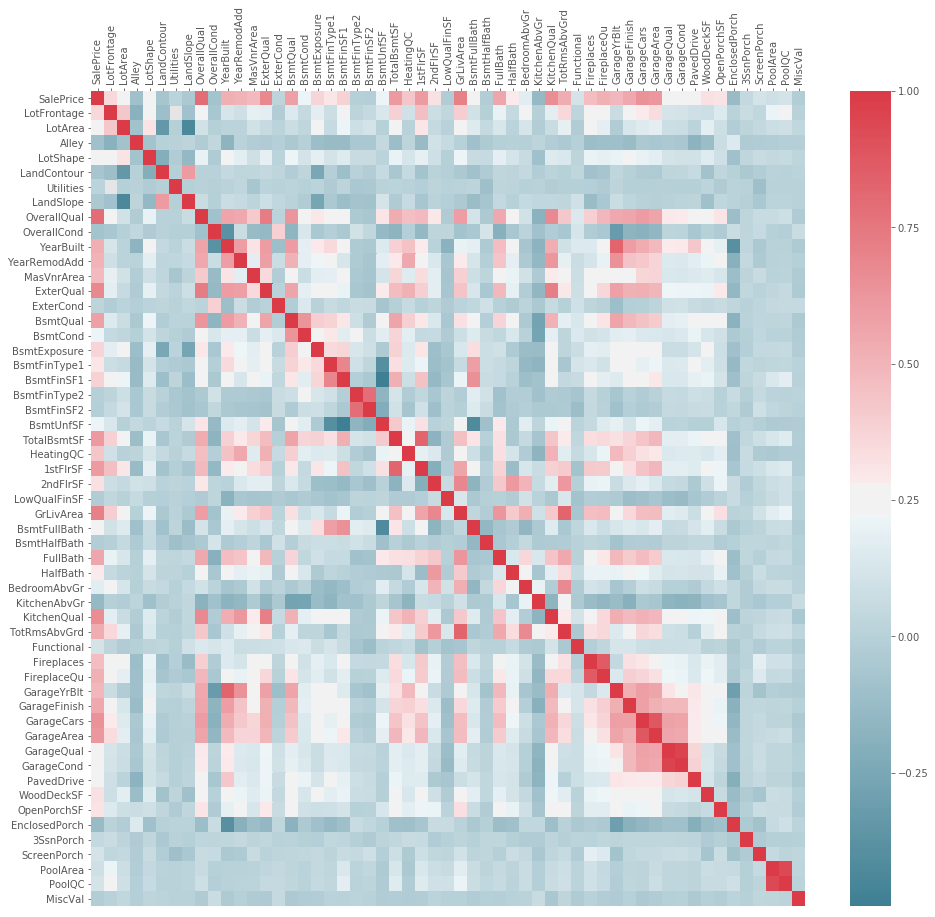

In [23]:
# Let's take a look at the correlation between numerical features
corr = train[['SalePrice'] + num_features].corr()
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

We see that there is quite bit of correlation between features, many of which one might expect to find, and perhaps some surprising ones. For example, we find that *GarageYrBlt* is highly correlated with *YearBuilt*, which means that most garages were built along with the house. *BsmtQual* correlates with *OverallQual* and *TotalBsmtSF* correlates highly with *1stFlrSF*, which both make a lot of sense. We also see that *KitchenQual* correlates highly with *ExteriorQual*; kitchens and housing exteriors are of course two separate things, but may point to a lurking variable, such as "new house": a newer house is likely to have both a better exterior and better kitchen. 

Let's hone in on how features correlate with *SalePrice*.

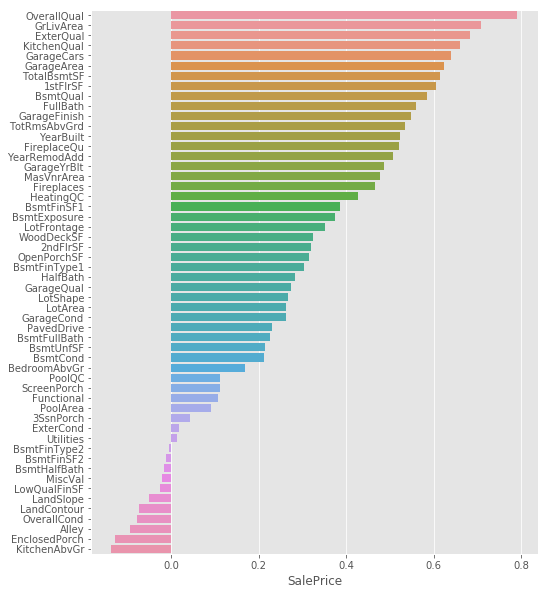

In [24]:
# Feature sorted by correlation to SalePrice, from positive to negative
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

The feature most correlated with *SalePrice* is *OverallQual*, which makes sense, followed by the size of the house (*GrLivArea*) and then three more quality related features: *ExterQual*, *KitchenQual*, and *BsmtQual*. We noted earlier that *ExterQual* and *KitchenQual* were highly correlated with one another, and now we find out that they are both also highly correlated with *SalePrice*. In regression we usually want to avoid including predictors highly correlated with one another to minimize **multicollinearity**. From [Wikipedia](https://en.wikipedia.org/wiki/Multicollinearity):
> In statistics, **multicollinearity** (also **collinearity**) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multiple regression model with colinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

In other words, if we include, for example, both *ExterQual* and *KitchenQual* in our regression, we won't be able to say which of those features is "more important" than the other (i.e. we can't trust their coefficients). But the overall predictive power of the model is not affected.

So do we care? I'd say no, because we're not really interested in *explaining* what exactly impacts the sales price of a house; the ultimate goal is to simply predict accurately what the sales price may be. 

## Categorical Features

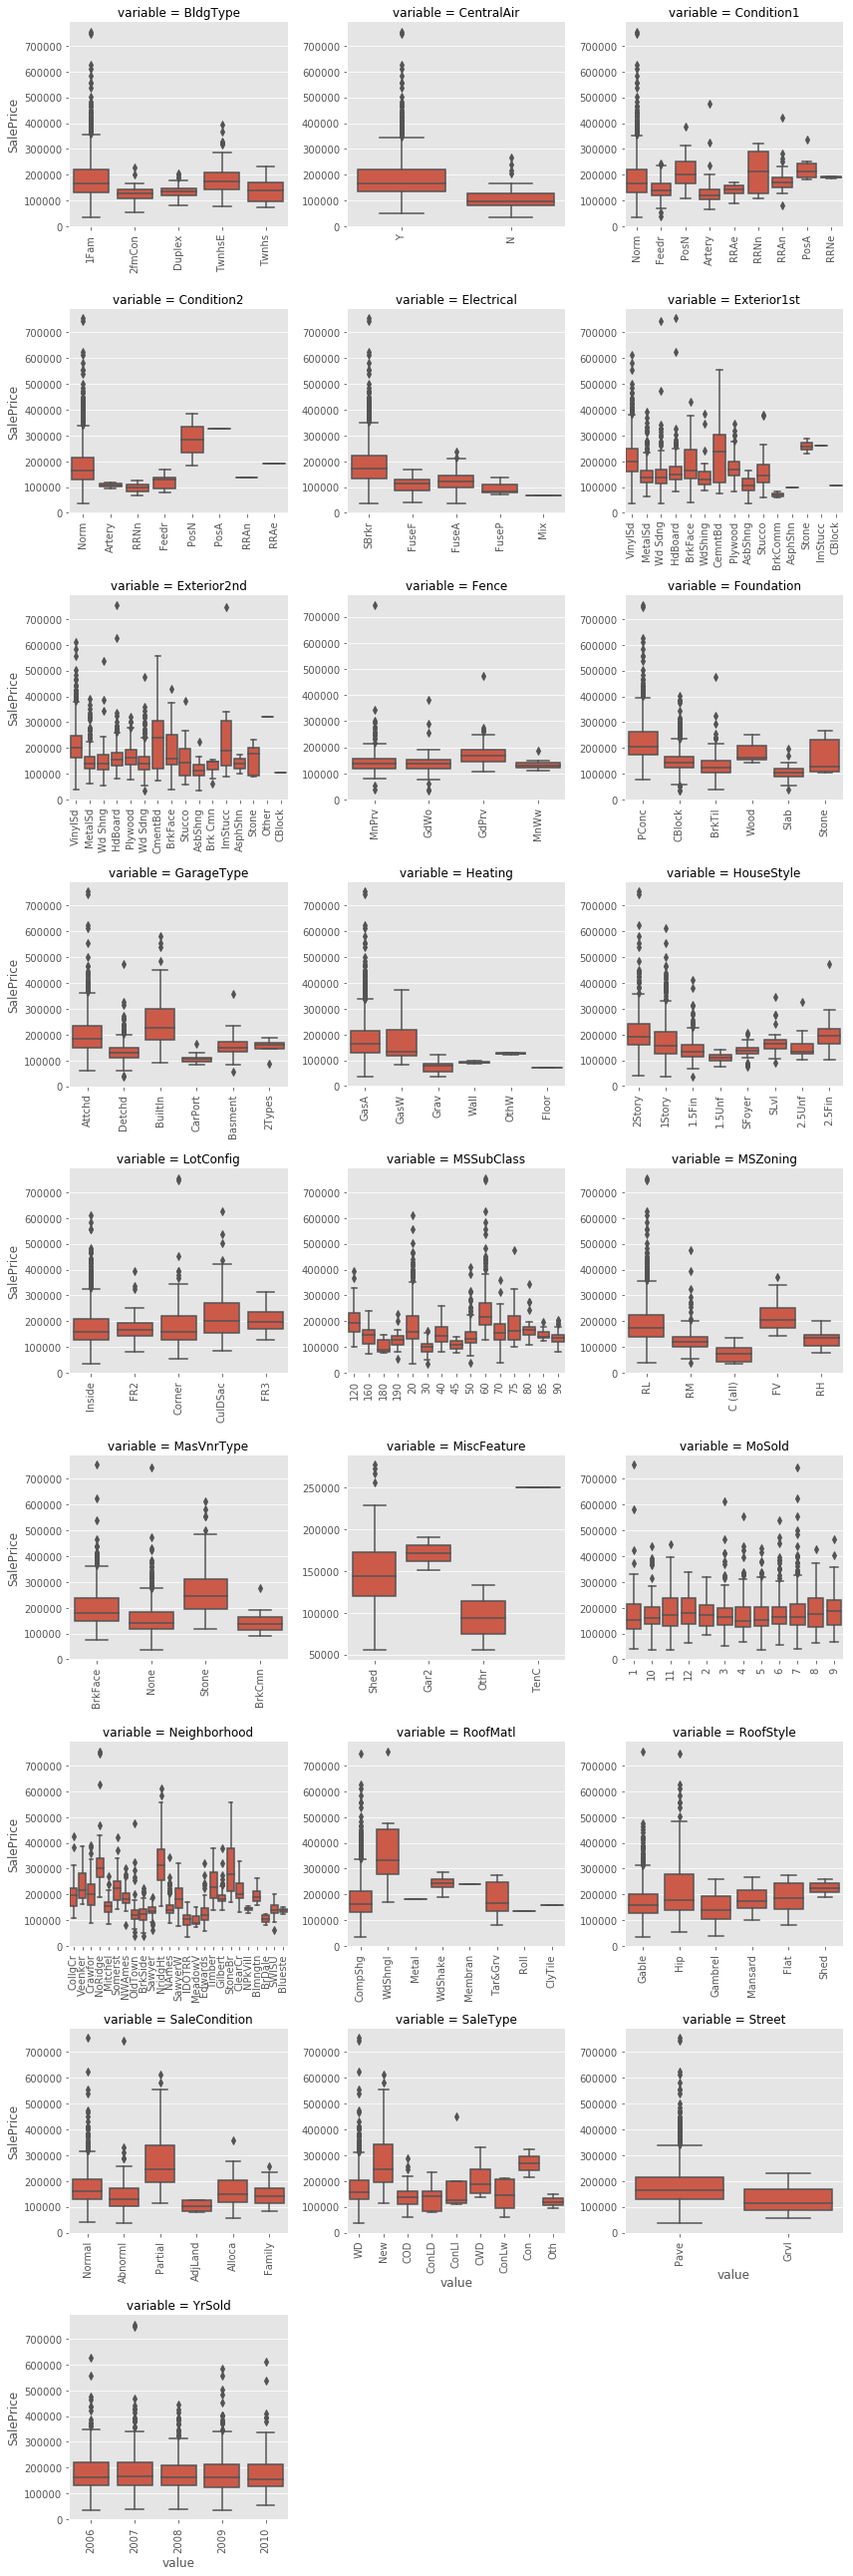

In [25]:
# Count plots of categorical features
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

It looks like some features show significant variance in the mean of *SalePrice* between different groups, eg. *Neighborhood*, *SaleType* or *MSSubClass*.

However, we’d like to have a better sense of which feature influences *SalePrice* more than others. What we’ll do is run one-way ANOVA tests for each categorical feature againt *SalePrice*. This will give us both the F statistic and p-values for each feature. The higher the F statistic, the higher the p-value (i.e. the more confident we can be in rejecting the null hypothesis), but since the p-value will take into consideration a given F distribution (based on number of groups and number of observations), we will ultimately sort the features by p-value (instead of F). What does the p-value tell us? Again it tells how confident we can be in rejecting the null hypothesis; put differently, it answers the question "how likely was it to see data for each group if each group had in reality no effect on the dependent variable?" The unlikelier it is, the greater the difference in groups and therefore the more significant of an influence the feature has on the dependent variable *SalePrice*.

Let's see what that looks like.

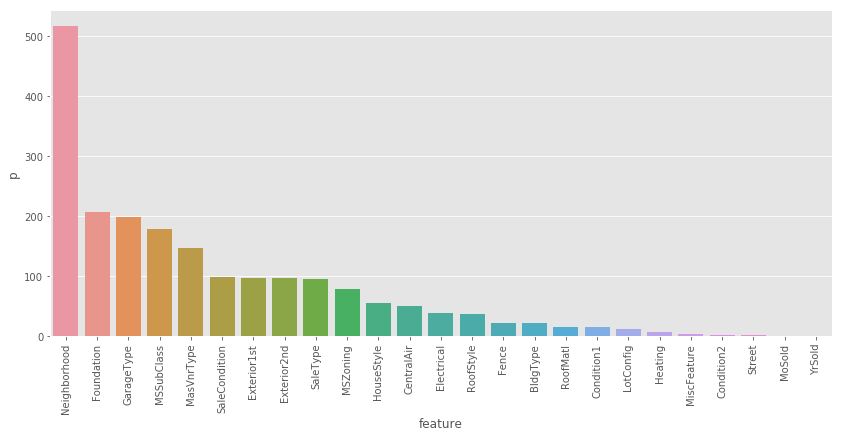

In [26]:
# In order for ANOVA to work, we have to take care of missing values first
train[cat_features] = train[cat_features].fillna('Missing')

# Onward...
anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
    group_prices = []
    for group in train[cat].unique():
        group_prices.append(train[train[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(anova.feature, np.log(1./anova['p']))
plt.xticks(rotation=90)
plt.show()

We confirm the old adage "location, location, location"! Of all our categorical features, *Neighborhood* appears to have the greatest influence on *SalePrice*. 

It's important to note here that the chart really undersells how much more influence *Neighborhood* has. We took the log of the inverse of the p-value (`np.log(1./anova['p']`): the inverse so that when we take the log we get positive numbers, and log so that we don't just see a single bar. In other words, the p-value is a magnitude of about 300 times smaller than the next feature!

### Bonus Plots
At this point we're about ready to formally process our data and get it ready for modelling, but before we do, let's look at a cool visualization that was new to me and does a great job showing the relationship between two categorical and one numerical variable.

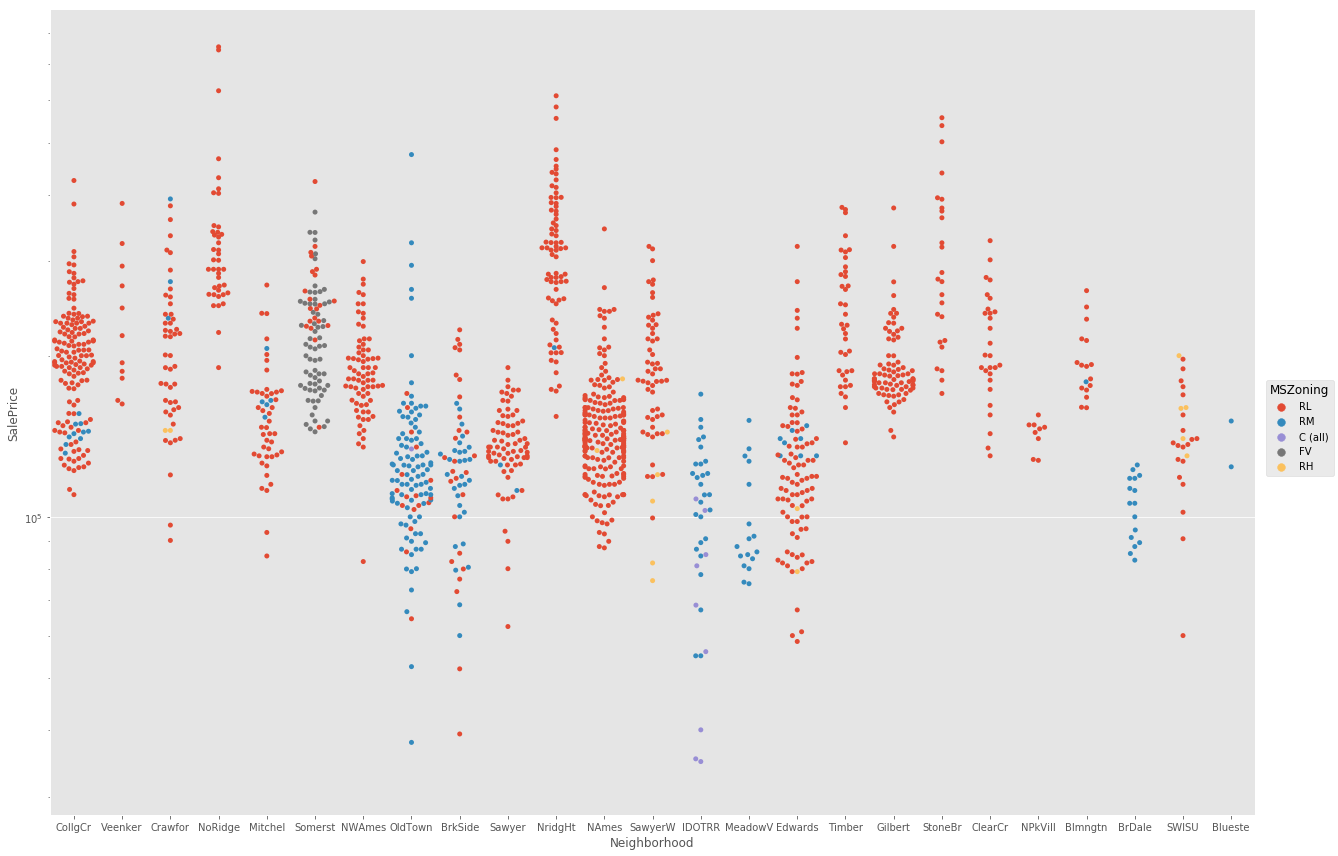

In [27]:
# Swarming Factorplot FTW
fig = sns.factorplot(x='Neighborhood', y='SalePrice', hue='MSZoning', data=train, kind='swarm', size=12, aspect=1.5)
ax = fig.axes[0][0]
ax.set_yscale('log')
plt.show()

Here we're looking at sales price by neighborhood and color-coding by zoning classificaton of the sale. It looks like there is clearly some strong relationships between some neighborhoods and zoning classifications: Old Town, Brooksize, Iowa DOT and Rail Road, Meadow Village and Briardale are all predominantly in a "Residental Medium Density" zone, while Somerset is in a "Floating Village Residential" zone (I'm assuming this might be like a gated community?)

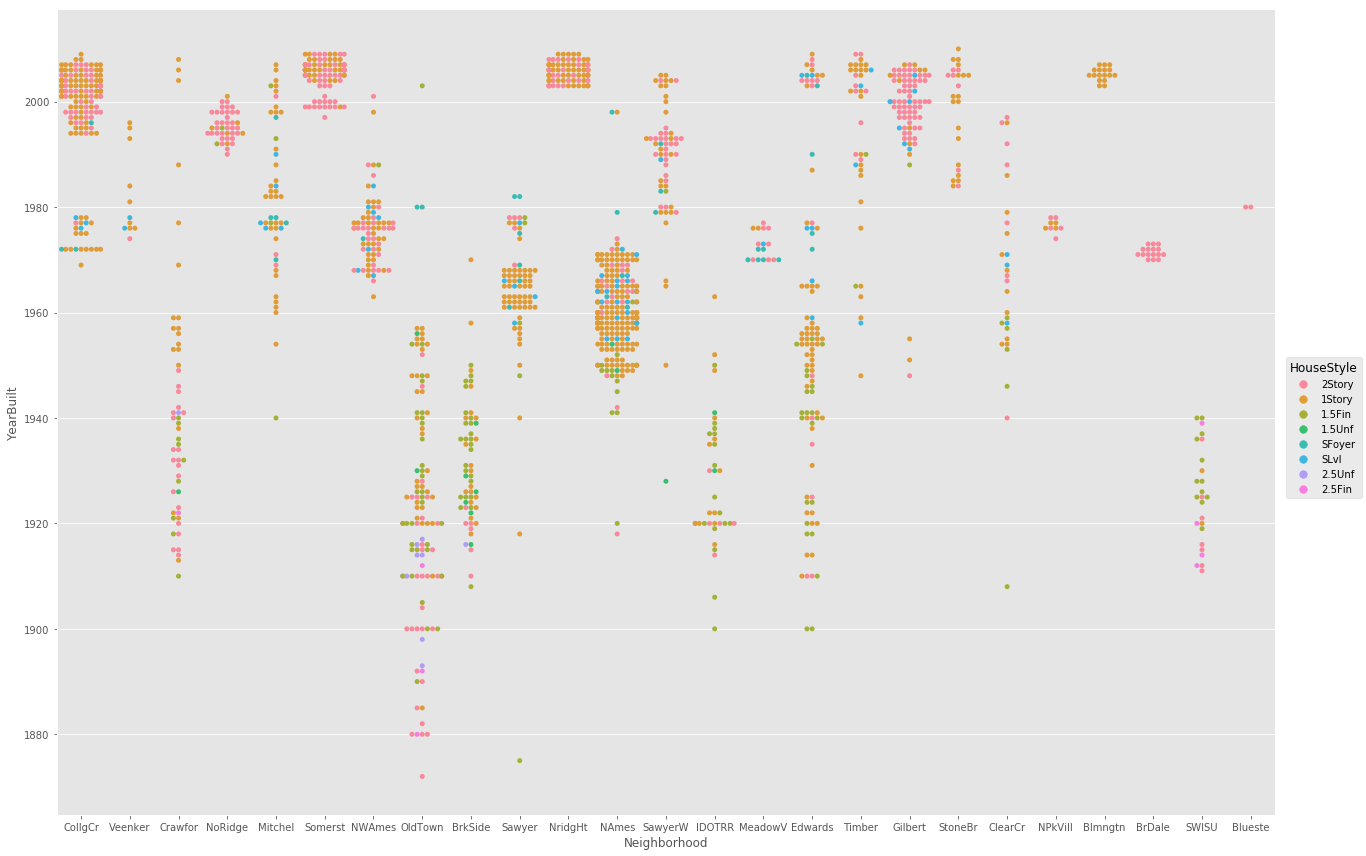

In [28]:
# Peering into the history of Ames, IA
fig = sns.factorplot(x='Neighborhood', y='YearBuilt', hue='HouseStyle', data=train, kind='swarm', size=12, aspect=1.5)
ax = fig.axes[0][0]
#ax.set_yscale('log')
#plt.show()

I imagine this type of chart to be quite interesting for an historian. We're plotting houses by the year they were built, in which neighborhood, and what kind of house style was used (e.g. "2.5Fin -> Two and one-half story: 2nd level finished"). We can easily see why Old Town is called Old Town: that's where houses were being built before 1900. We see some neighborhoods gradually developing, like Crawford, while others were developed in a short amount of time, e.g. Northridge Heights or College Creek. It also looks like the housing style changed over time, and in some cases clusters in a neighborhood. For example, the 50s and 60s were a popular time for one story houses (I'm picturing post-WWII newly built suburbs), while two-story houses were more in vogue in the 90s. "Split Foyer" had their golden age in the 70s. As we noted earlier, there seems to have been a dearth in houses built in the 80s for some reason. 

Ok, enough with this history lesson, let's move on. 

# Data Preprocessing

## De-duplication
Let's double-check to to see that we don't have any dupes in our data.

In [29]:
# To check for dupes, let's just get the original dataset
# and make sure that no Parcel IDs appear twice, possibly 
# from resales
original_dataset = 'https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt'
og = pd.read_table(original_dataset)
print('There are {} duplicate observations'.format(og.PID.count() - og.PID.nunique()))

There are 0 duplicate observations


In [30]:
# ... and let's just get peace of mind for our data
print('Train set duplicate IDs: {}'.format(train.duplicated('Id').sum()))
print('Test set duplicate IDs: {}'.format(test.duplicated('Id').sum()))

Train set duplicate IDs: 0
Test set duplicate IDs: 0


## Missing Data
In the course of our analysis, we've actually had to deal with missing values already. Let's document here what we've already done and see if there are any missing value left we have to deal with. 

Earlier when we converted several categorical features to numerical we also filled in any missing values with 0. This made sense as those categorical feature values had rank, so when we converted the values to 1, 2, 3, etc. it seems like it only makes sense to set missing values equal to 0.  We did this for the following features: *Alley, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, ExterCond, ExterQual, FireplaceQu, Functional, GarageCond, GarageFinish, GarageQual, HeatingQC, KitchenQual, LandContour, LandSlope, LotShape, PavedDrive, PoolQC, Utilities*.

Prior to doing the ANOVA evaluation of categorial features, we filled the missing values with simply "Missing". Let's see what impact that had.

In [31]:
# Categorical features with "Missing" values
missing_values = (train[cat_features] == 'Missing').sum().sort_values(ascending=False)
missing_values[missing_values > 0]

MiscFeature    1406
Fence          1179
GarageType       81
MasVnrType        8
Electrical        1
dtype: int64

In [32]:
# Since there's only one missing Electrical, let's
# set it equal to the most common type
train.loc[train.Electrical == 'Missing', 'Electrical'] = train.Electrical.mode()[0]

In [33]:
# There's a tiny mistake that crept into our data.
# Unlike some other features, for MasVnrType "None" 
# was actually called out as an explicit value. 
# Now we have "None" and "Missing"
train.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Missing      8
Name: MasVnrType, dtype: int64

In [34]:
# Let's change "Missing" to "None" here.
train.MasVnrType.replace({'Missing':'None'}, inplace=True)

In [35]:
# We also notice a data discrepancy, we have 
# houses with MasVnrType == None but MasVnrArea > 0 and
# house with MasVnrArea == 0 but MasVnrType != None
# Let's fix these with the assumption that there was a mason veneer
train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea > 1), 'MasVnrType'] = 'BrkFace' # most common 
train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea == 1), 'MasVnrArea'] = 0 # 1 sq ft is basically 0
for vnr_type in train.MasVnrType.unique():
    # so here we set the area equal to the mean of the given veneer type
    train.loc[(train.MasVnrType == vnr_type) & (train.MasVnrArea == 0), 'MasVnrArea'] = \
        train[train.MasVnrType == vnr_type].MasVnrArea.mean() 


Now let's see what's left over.

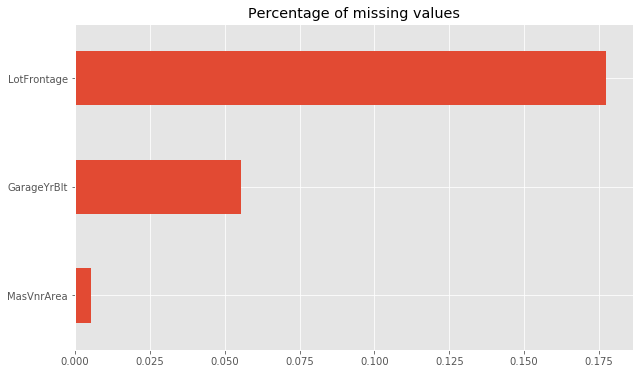

In [36]:
# Remaining missing values
missing_data = train.isnull().sum() / train.shape[0]
missing_data[missing_data > 0].\
    sort_values(ascending=True).\
    plot(kind='barh', figsize=(10,6))
plt.title('Percentage of missing values')
plt.show()

In [37]:
# LotFrontage is "Linear feet of street connected to property"
# Since it seems unlikely that there's no street connected
# to a lot, we'll set it equal to the median LotFrontage of that street.
train.LotFrontage = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [38]:
# MasVnrArea is "Masonry veneer area in square feet"
# This feature consists of a majority of 0 values, so 
# it's odd to find missing values here. Let's set to 0
train.MasVnrArea.fillna(0, inplace=True)

In [39]:
# Since GarageYrBlt missing means there's no garage
# we'll set it equal to 0
train.GarageYrBlt.fillna(0, inplace=True)

In [40]:
# Anything left?
train.isnull().sum().sum()

0

## Outliers
We recall that the [dataset documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) mentioned that there were outliers and that we should probably get rid of them:
> There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

Let's check it out for ourselves.

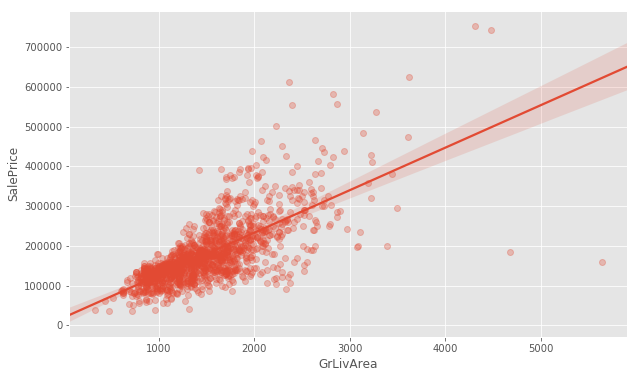

In [41]:
# First we visually inspect a scatter plot of GrLivArea vs. SalePrice
plt.figure(figsize=(10,6))
sns.regplot(train.GrLivArea, train.SalePrice, scatter_kws={'alpha':0.3})
plt.show()

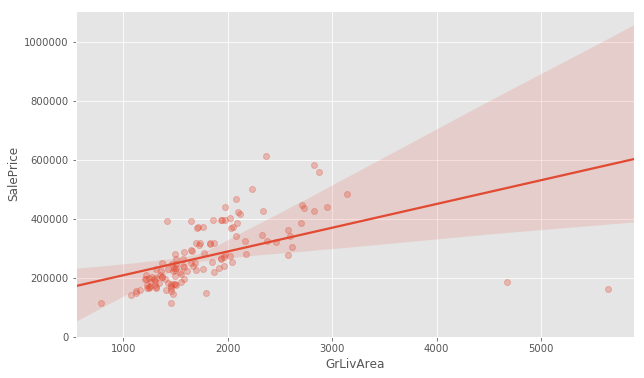

In [42]:
# We see the outliers but are also interested in those Partial Sale outliers
plt.figure(figsize=(10,6))
sns.regplot(train[train.SaleCondition == 'Partial'].GrLivArea,
            train[train.SaleCondition == 'Partial'].SalePrice, scatter_kws={'alpha':0.3})
plt.show()

In [43]:
# We heed the author's advice and cut out anything over 4,000 sq ft
train.drop(train[train.GrLivArea >= 4000].index, inplace=True)

## More Feature Enginnering

In [44]:
# Let's add some additional features

# Total Square Footage
train['TotalSF'] = train.TotalBsmtSF + train.GrLivArea
train['TotalFloorSF'] = train['1stFlrSF'] + train['2ndFlrSF']
train['TotalPorchSF'] = train.OpenPorchSF + train.EnclosedPorch + \
    train['3SsnPorch'] + train.ScreenPorch
    
# Total Bathrooms
train['TotalBathrooms'] = train.FullBath + .5 * train.HalfBath + \
    train.BsmtFullBath + .5 * train.BsmtHalfBath

# Booleans
train['HasBasement'] = train.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train.GarageArea.apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train.TotalPorchSF.apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train.PoolArea.apply(lambda x: 1 if x > 0 else 0)
train['WasRemodeled'] = (train.YearRemodAdd != train.YearBuilt).astype(np.int64)
train['IsNew'] = (train.YearBuilt > 2000).astype(np.int64)
train['WasCompleted'] = (train.SaleCondition != 'Partial').astype(np.int64)

boolean_features = ['HasBasement', 'HasGarage', 'HasPorch', 'HasPool', 
                    'WasRemodeled', 'IsNew', 'WasCompleted']

In [45]:
num_features, cat_features = get_feature_groups()
num_features = [f for f in num_features if f not in boolean_features]

## Transforms
Earlier we noted that some of the numerical features exhibit positive skew and could benefit from a log transform. Let's go ahead and do that now.

In [46]:
# Here we will be simplistic about it and simply
# log transform any numerical feature with a 
# skew greater than 0.5
features = num_features + ['SalePrice']
for f in features:
    train.loc[:,f] = np.log1p(train[f])

## Dummy Variables
We'll one-hot encode all of our categorical features now.

In [47]:
# before we continue, let's drop some cols
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
train.drop('Id', axis=1, inplace=True)

In [48]:
# ... and go
model_data = pd.get_dummies(train).copy()

# Modelling

## Partition
We want to divide our data into three parts: a training, validation, and testing set. We use our validation set to optimize hyperparameters and ultimately get a score at the very end using our test set. However, in order to not throw out too much data for training, we will use a cross validation strategy whereby random groups of our training set will be held out for validation scoring and finally average

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
# Split data intro train and validation sets
X_train, X_test, y_train, y_test = \
    train_test_split(model_data.copy(), y, test_size=0.3, random_state=42)
print('Shapes')
print('X_train:', X_train.shape)
print('X_val:', X_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_test.shape)

Shapes
X_train: (1019, 263)
X_val: (437, 263)
y_train: (1019,)
y_val: (437,)


## Standardize
Next we'll standardize our numerical data, meaning we center the feature means at 0 with standard deviation of 1. This makes it easier to learn weights. 

In [51]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [52]:
# We'll use the convenient sklearn RobustScaler.
# Note we're only standardizing numerical features, not
# the dummy features. The RobustScaler helps us deal with outliers.
stdsc = StandardScaler()
X_train.loc[:,num_features] = stdsc.fit_transform(X_train[num_features])
X_test.loc[:,num_features] = stdsc.transform(X_test[num_features])

## Errors

From the competition evaluation page:
> Submissions are evaluated on [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

On the Wikipedia page we find the definition of RMSE (aka RMSD for "Deviation"):
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/197385368628b8495a746f7bd490d3d1cc83e86c' />

In [53]:
from sklearn.model_selection import cross_val_score

In [54]:
def rsme(model, X, y):
    cv_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    return np.sqrt(cv_scores)

## Ordinary Least Squares (OLS) Linear Regression, No Regularization
We'll start by doing a simple OLS LR and see how we do.

Linear regression models can be heavily impacted by outliers, and I in fact ran into this very issue when I started running models. I ended up discovering that keeping all of the dummy features was blowing up the coefficients, and thereby the predictions and RSME.

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
# What we're doing here is adding the dummy features for 
# one categorical feature at a time and running the regression.
dummy_cols = [col for col in model_data.columns if col not in num_features]
features_to_try = []
for cat in cat_features:
    cat_dummies = [c for c in dummy_cols if c.startswith(cat)]
    features_to_try += cat_dummies
    X_train_subset = X_train[num_features + boolean_features + features_to_try]
    X_test_subset = X_test[num_features + boolean_features + features_to_try]
    
    lr = LinearRegression()
    lr.fit(X_train_subset, y_train)
    
    print('Dummy Features: {} | Train RSME: {:.3f} | Test RSME: {:.3f}'.format(
        len(features_to_try), rsme(lr, X_train_subset, y_train).min(), rsme(lr, X_test_subset, y_test).min()))

Dummy Features: 15 | Train RSME: 0.093 | Test RSME: 0.098
Dummy Features: 20 | Train RSME: 0.093 | Test RSME: 0.100
Dummy Features: 22 | Train RSME: 0.093 | Test RSME: 0.097
Dummy Features: 27 | Train RSME: 0.093 | Test RSME: 0.097
Dummy Features: 52 | Train RSME: 0.092 | Test RSME: 0.091
Dummy Features: 61 | Train RSME: 0.095 | Test RSME: 0.093
Dummy Features: 69 | Train RSME: 0.117 | Test RSME: 0.096
Dummy Features: 74 | Train RSME: 0.090 | Test RSME: 0.096
Dummy Features: 82 | Train RSME: 0.088 | Test RSME: 0.097
Dummy Features: 88 | Train RSME: 0.121 | Test RSME: 0.096
Dummy Features: 95 | Train RSME: 0.120 | Test RSME: 0.096
Dummy Features: 110 | Train RSME: 0.116 | Test RSME: 0.104
Dummy Features: 126 | Train RSME: 0.113 | Test RSME: 0.116
Dummy Features: 130 | Train RSME: 0.119 | Test RSME: 4069775906.947
Dummy Features: 136 | Train RSME: 0.113 | Test RSME: 209064192.065
Dummy Features: 142 | Train RSME: 0.093 | Test RSME: 200401014.680
Dummy Features: 144 | Train RSME: 29301824

We can see that both the Train as well as Test RSME score ends up exploding, so let's skip ahead to regressions using regularization, which keep just this type of issue from happening.

## Ridge Regression
Ridge Regression is an L2 penalized model where the squared sum of the weights are added to the OLS cost function.

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [58]:
# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']
ridge = ridge.best_estimator_

print('Ridge -> Train RSME: {:.5f} | Test RSME: {:.5f} | alpha: {:.5f}'.format(
    rsme(ridge, X_train, y_train).mean(), rsme(ridge, X_test, y_test).mean(), alpha))

Ridge -> Train RSME: 0.11516 | Test RSME: 0.12489 | alpha: 20.00000


In [59]:
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='orange', marker='s', label='Validation data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='red')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test, c='orange', marker='s', label='Validation data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
    plt.show()

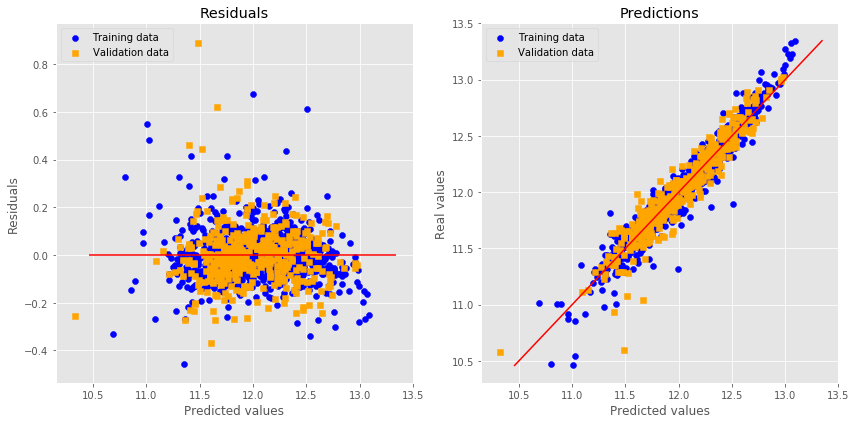

In [60]:
model_evaluation_plots(ridge, X_train, y_train, X_test, y_test)

Looking at the residual plot, we see that the residuals are randomly distributed around the center line, which is good. If we saw patterns here it means that the model is unable to capture some explanatory information. We see that our predictions plotted against real values center around the line of perfect fit, again a good sign

Ridge dropped 3 of 263 features.


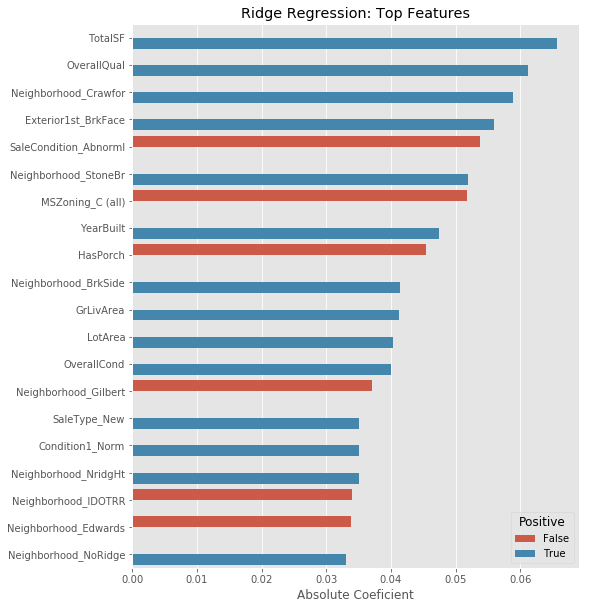

In [61]:
# Let's take a look at what the Ridge regression made of our features.
coefs = pd.DataFrame({'coefs':ridge.coef_,'Positive':ridge.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('Ridge dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('Ridge Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

This seems to make a lot of sense. What drives house price? House size, quality, neighborhood, age...

## LASSO Regression
THe LASSO (Least Absolute Shrinkage and Selection Operator) regression is an L1 regularizaton model in which the sum of weights is added to the cost function

In [62]:
from sklearn.linear_model import Lasso

In [63]:
# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print('Lasso -> Train RSME: {:.5f} | Test RSME: {:.5f} | alpha: {:.5f}'.format(
    rsme(lasso, X_train, y_train).mean(), rsme(lasso, X_test, y_test).mean(), alpha))

Lasso -> Train RSME: 0.11433 | Test RSME: 0.11923 | alpha: 0.00070


Nice! We've improved our Train and Test score and reduced the difference between the two, suggesting we are dealing with overfitting.

LASSO dropped 166 of 263 features.


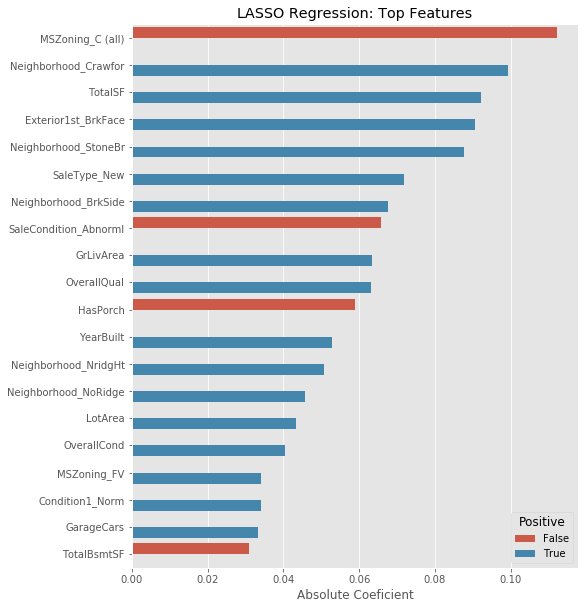

In [64]:
# Let's take a look at what the LASSO regression made of our features.
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

Interesting. LASSO dropped almost 2/3 of features. Some of the negative coefficients also surprise me, e.g. *HasPorch* and *TotalBsmtSF*.

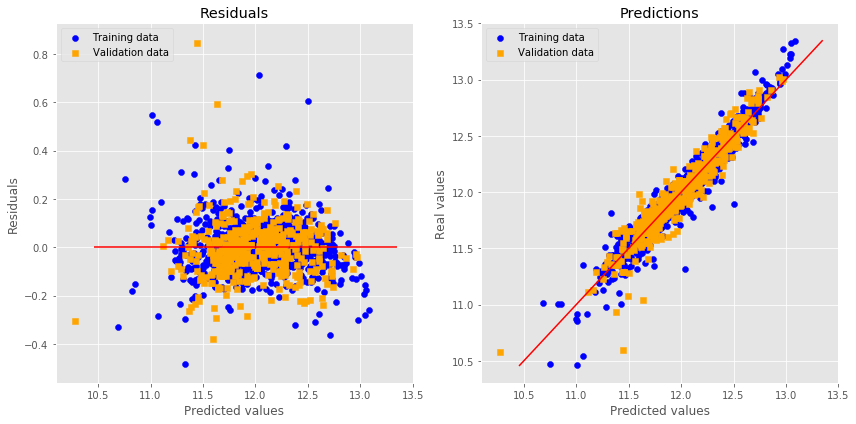

In [65]:
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

## Kernel Ridge Regression

Kernel Ridge Regression combines ridge regression with the kernel trick.

In [66]:
from sklearn.kernel_ridge import KernelRidge

In [67]:
param_grid = {'alpha': [1e0, 1e-1, 1e-2],
              'kernel': ['polynomial'],
              'degree': [2,3,4],
              'gamma': [1e-2, 1e-3, 1e-4]}
krr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
krr.fit(X_train, y_train)
alpha = krr.best_params_['alpha']
degree = krr.best_params_['degree']
gamma = krr.best_params_['gamma']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 25)],
              'kernel': ['polynomial'],
              'degree': [degree],
              'gamma': [x/100. * gamma for x in range(50, 151, 50)]}
krr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
krr.fit(X_train, y_train)
alpha = krr.best_params_['alpha']
degree = krr.best_params_['degree']
gamma = krr.best_params_['gamma']
krr = krr.best_estimator_

print('Ridge -> Train RSME: {:.5f} | Test RSME: {:.5f} | alpha: {:.5f} | degree: {} | gamma: {:.5f}'.format(
    rsme(ridge, X_train, y_train).mean(), rsme(ridge, X_test, y_test).mean(), alpha, degree, gamma))

Ridge -> Train RSME: 0.11516 | Test RSME: 0.12489 | alpha: 0.05000 | degree: 4 | gamma: 0.00050


LASSO still seems to perform better.

# Conclusion

We started off building an intuition about the data, dove into the details, made decisions about what to do with our features, and finally compared several different regression models. In the end we achieved the best results using the LASSO regression. 

Next steps would be to do additional feature engineering, further experiment with other models, and start combining them into ensembles to push the envelope. 

I hope this notebook was helpful, and if you see any mistakes, have any questions, or any other comments, please leave them below. 

Thanks for reading!